<a href="https://colab.research.google.com/github/fnovoas/sinrepco/blob/main/Sinrepco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SINREPCO
por fnovoas@unal.edu.co

Para cargar un modelo de Sinrepco ya hecho (entrenado), ejecutamos en orden los pasos **1**, **2.a.**, **8** y **3.b.**. Luego, podemos evaluarlo en el **paso 6**.\
Para crear y entrenar un modelo de Sinrepco nuevo, ejecutamos los pasos en orden en la misma sesión.

1. Instalamos e importamos las bibliotecas necesarias: TensorFlow para el desarrollo de modelos de inteligencia artificial, OpenCV para el procesamiento de imágenes y Tesseract para el reconocimiento óptico de caracteres (OCR).

In [4]:
!pip install tensorflow opencv-python pytesseract
#importamos las bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

2. 2.a. Procedemos con la recolección de datos, reunimos un conjunto de datos que contiene imágenes de vehículos, tanto contaminantes como no contaminantes, estas imágenes fueron capturadas por mí en diversas ubicaciones. Contamos con 3509 imágenes de vehículos no chimenea y 615 imágenes de vehículos chimenea.
Separamos las imágenes manualmente (por inspección) según si contienen vehículos que emiten humo visible o no, en dos carpetas: "chimenea" y "no_chimenea", contenidas en un directorio raíz "sinrepco_fotos" en mi unidad de Drive. Con estos datos entrenaremos al modelo.\
Montamos Drive para acceder a las imágenes.


In [5]:
from google.colab import drive
import os

# Montar el Google Drive
drive.mount('/content/drive')

# Directorio base donde está la carpeta "sinrepco_fotos"
base_dir = "/content/drive/My Drive/sinrepco_fotos"

# Función para contar archivos en una carpeta
def contar_archivos_en_carpeta(carpeta):
    return len([f for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))])

# Recorrer todas las carpetas y subcarpetas en el directorio base
for root, dirs, files in os.walk(base_dir):
    for dir_name in dirs:
        carpeta_actual = os.path.join(root, dir_name)
        num_archivos = contar_archivos_en_carpeta(carpeta_actual)
        print(f"Carpeta encontrada: {carpeta_actual} - Archivos: {num_archivos}")

# Función para cambiar extensión .JPG a .jpg en una carpeta y sus subcarpetas
def cambiar_extensiones_a_minusculas(carpeta):
    cambios_realizados = False
    for root, dirs, files in os.walk(carpeta):
        for filename in files:
            if filename.endswith(".JPG"):
                old_file = os.path.join(root, filename)
                new_file = os.path.join(root, filename.lower())
                os.rename(old_file, new_file)
                cambios_realizados = True
    if cambios_realizados:
        print("Extensiones de archivo cambiadas de .JPG a .jpg.")

# Aplicar cambio de extensiones en la raíz y en todas las subcarpetas
cambiar_extensiones_a_minusculas(base_dir)

# Verificar cuántas imágenes hay en cada carpeta
for root, dirs, files in os.walk(base_dir):
    for dir_name in dirs:
        carpeta_actual = os.path.join(root, dir_name)
        num_archivos = len([f for f in os.listdir(carpeta_actual) if os.path.isfile(os.path.join(carpeta_actual, f))])
        print(f"Archivos en {carpeta_actual}: {num_archivos}")


Mounted at /content/drive
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/chimenea - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/no_chimenea - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/test - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train/chimenea - Archivos: 2152
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train/no_chimenea - Archivos: 2456
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation/chimenea - Archivos: 461
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation/no_chimenea - Archivos: 526
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/test/chimenea - Archivos: 462
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/test/no_chimenea - Archivos: 527
Archivo

2.b. **(Solo hace falta ejecutar este código si no tenemos suficientes imágenes de vehículos chimenea)** Actualización: La [primera vez](https://github.com/fnovoas/sinrepco/blob/faf332cb9eff6f27528e503c696db6909bab49a5/Sinrepco.ipynb) que ejecutamos el paso 5, encontramos que el modelo estaba clasificando incorrectamente la mayoría de las imágenes de la clase "no_chimenea" como "chimenea"; esto se debe al desequilibrio de clases en el conjunto de datos. Para compensar la falta de fotos de vehículos chimenea, **generamos imágenes sintéticamente** (a partir de las imágenes existentes) para guardarlas en la carpeta "chimenea". Eliminaremos este paso una vez que hayamos aumentado la cantidad de datos de vehículos chimenea (esto es, cuando les tome más fotos).

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import time

# Directorio de la carpeta chimenea
chimenea_dir = f'{base_dir}/chimenea'

# Configuración del ImageDataGenerator para aumentar datos
datagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Cargar imágenes desde la carpeta chimenea
for filename in os.listdir(chimenea_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(chimenea_dir, filename)
        img = tf.keras.preprocessing.image.load_img(img_path)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.reshape((1,) + x.shape)  # Redimensionar para el generador

        # Generar 4 imágenes sintéticas por cada imagen original
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=chimenea_dir, save_prefix=f'aug_{i}_{int(time.time())}', save_format='jpg'):
            i += 1
            time.sleep(0.3)  # Esperar 0.3 segundos antes de generar la siguiente imagen
            if i >= 4:
                break

# Contar y mostrar el número total de imágenes en la carpeta chimenea
print("Imágenes sintéticas generadas.")
time.sleep(10)  # Esperar 10 segundos
total_files = len(os.listdir(chimenea_dir))
print(f"Total de archivos encontrados en {chimenea_dir}: {total_files}")


Imágenes sintéticas generadas.
Total de archivos encontrados en /content/drive/My Drive/sinrepco_fotos/chimenea: 3075


3. 3.a. **(Solo hace falta ejecutar este código cada vez que incorporemos nuevos datos, al hacerlo, deben estar guardados en las carpetas originales "chimenea" y "no_chimenea" en el directorio raíz respectivamente)** Cargamos y preparamos los datos de la carpeta en donde están almacenados en Drive. Este código divide las imágenes en conjuntos de entrenamiento, validación y prueba según el porcentaje especificado: el 70% de los datos irán en entrenamiento y el 15% en cada una de las otras dos categorías. Ejecutar este código cambia la estructura de la organización de los archivos y carpetas en Drive.

In [ ]:
import os
import random
import shutil
import time
# Crear directorios si no existen
base_dir = '/content/drive/My Drive/sinrepco_fotos'
source_chimenea = f'{base_dir}/chimenea'
source_no_chimenea = f'{base_dir}/no_chimenea'

train_chimenea_dir = f'{base_dir}/train/chimenea'
val_chimenea_dir = f'{base_dir}/validation/chimenea'
test_chimenea_dir = f'{base_dir}/test/chimenea'

train_no_chimenea_dir = f'{base_dir}/train/no_chimenea'
val_no_chimenea_dir = f'{base_dir}/validation/no_chimenea'
test_no_chimenea_dir = f'{base_dir}/test/no_chimenea'

os.makedirs(train_chimenea_dir, exist_ok=True)
os.makedirs(val_chimenea_dir, exist_ok=True)
os.makedirs(test_chimenea_dir, exist_ok=True)
os.makedirs(train_no_chimenea_dir, exist_ok=True)
os.makedirs(val_no_chimenea_dir, exist_ok=True)
os.makedirs(test_no_chimenea_dir, exist_ok=True)

def move_files(files, source, destination):
    for f in files:
        src_path = os.path.join(source, f)
        dest_path = os.path.join(destination, f)
        shutil.move(src_path, dest_path)
        # Verifica si el archivo se movió correctamente
        if not os.path.exists(dest_path):
            print(f"Reintentando mover: {f}")
            shutil.move(src_path, dest_path)
            # Da tiempo al sistema para procesar la operación
            time.sleep(0.5)

def move_data(SOURCE, TRAINING, VALIDATION, TEST, split_train=0.7, split_val_test=0.15):
    files = [f for f in os.listdir(SOURCE) if os.path.isfile(os.path.join(SOURCE, f))]
    print(f"Total de archivos encontrados en {SOURCE}: {len(files)}")  # Imprime el número total de archivos encontrados

    random.shuffle(files)

    train_size = int(len(files) * split_train)
    val_size = int(len(files) * split_val_test)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    print(f"Moviendo {len(train_files)} archivos a {TRAINING}")  # Imprime cuántos archivos se moverán al entrenamiento
    print(f"Moviendo {len(val_files)} archivos a {VALIDATION}")  # Imprime cuántos archivos se moverán a validación
    print(f"Moviendo {len(test_files)} archivos a {TEST}")  # Imprime cuántos archivos se moverán a prueba

    # Mueve los archivos en lotes para evitar problemas con demasiadas operaciones a la vez
    batch_size = 100  # Ajusta este tamaño según sea necesario
    for i in range(0, len(train_files), batch_size):
        move_files(train_files[i:i+batch_size], SOURCE, TRAINING)

    for i in range(0, len(val_files), batch_size):
        move_files(val_files[i:i+batch_size], SOURCE, VALIDATION)

    for i in range(0, len(test_files), batch_size):
        move_files(test_files[i:i+batch_size], SOURCE, TEST)

# Ejecutar esta función para cada clase
move_data(source_chimenea, train_chimenea_dir, val_chimenea_dir, test_chimenea_dir)
move_data(source_no_chimenea, train_no_chimenea_dir, val_no_chimenea_dir, test_no_chimenea_dir)

Total de archivos encontrados en /content/drive/My Drive/sinrepco_fotos/chimenea: 3075
Moviendo 2152 archivos a /content/drive/My Drive/sinrepco_fotos/train/chimenea
Moviendo 461 archivos a /content/drive/My Drive/sinrepco_fotos/validation/chimenea
Moviendo 462 archivos a /content/drive/My Drive/sinrepco_fotos/test/chimenea
Total de archivos encontrados en /content/drive/My Drive/sinrepco_fotos/no_chimenea: 3509
Moviendo 2456 archivos a /content/drive/My Drive/sinrepco_fotos/train/no_chimenea
Moviendo 526 archivos a /content/drive/My Drive/sinrepco_fotos/validation/no_chimenea
Moviendo 527 archivos a /content/drive/My Drive/sinrepco_fotos/test/no_chimenea


3.b. Después de dividir los datos, configuramos el ImageDataGenerator para cargar las imágenes de estas nuevas carpetas:

In [8]:
#importamos las bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import the ImageDataGenerator class
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
print('Los generadores de datos de entrenamiento, validación y prueba encontraron, respectivamente:\n')
# Parámetros (reducir estos valores si nos quedamos sin RAM)
IMG_HEIGHT = 450
IMG_WIDTH = 600
BATCH_SIZE = 8

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f'{base_dir}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    f'{base_dir}/validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    f'{base_dir}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Los generadores de datos de entrenamiento, validación y prueba encontraron, respectivamente:

Found 4608 images belonging to 2 classes.
Found 987 images belonging to 2 classes.
Found 989 images belonging to 2 classes.


4. Ahora definimos la arquitectura de la CNN. Tomamos una estructura de red neuronal convolucional, que es adecuada para el análisis de imágenes.

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# Definir la arquitectura de la CNN
model = Sequential([
    Input(shape=(450, 600, 3)),  # Especificamos la forma de entrada aquí
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

5. Entrenamos el modelo. Si bien el número de épocas recomendado normalmente (el número de veces que el modelo recorre todo el conjunto de datos para entrenarse) es de 20, usamos 7 para ajustarnos con el tiempo de ejecución máximo disponible (12h). *Ejecutar este código tomó máximo 11 horas y 42 minutos*.

In [8]:
EPOCHS = 7

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


576/576 ━━━━━━━━━━━━━━━━━━━━ 5982s 10s/step - accuracy: 0.6725 - loss: 0.7284 - val_accuracy: 0.7670 - val_loss: 0.4859
Epoch 2/7
576/576 ━━━━━━━━━━━━━━━━━━━━ 5920s 10s/step - accuracy: 0.8232 - loss: 0.4068 - val_accuracy: 0.7801 - val_loss: 0.5022
Epoch 3/7
576/576 ━━━━━━━━━━━━━━━━━━━━ 5871s 10s/step - accuracy: 0.9001 - loss: 0.2437 - val_accuracy: 0.8744 - val_loss: 0.3641
Epoch 4/7
576/576 ━━━━━━━━━━━━━━━━━━━━ 5876s 10s/step - accuracy: 0.9450 - loss: 0.1456 - val_accuracy: 0.8146 - val_loss: 0.5174
Epoch 5/7
576/576 ━━━━━━━━━━━━━━━━━━━━ 5849s 10s/step - accuracy: 0.9762 - loss: 0.0756 - val_accuracy: 0.8308 - val_loss: 0.7199
Epoch 6/7
576/576 ━━━━━━━━━━━━━━━━━━━━ 5851s 10s/step - accuracy: 0.9863 - loss: 0.0468 - val_accuracy: 0.8490 - val_loss: 0.6351
Epoch 7/7
576/576 ━━━━━━━━━━━━━━━━━━━━ 5903s 10s/step - accuracy: 0.9831 - loss: 0.0537 - val_accuracy: 0.8531 - val_loss: 0.7507


6. **Evaluamos** el modelo.
6.a. Gráficas de pérdida y precisión (*accuracy*). Este paso requiere acceso al historial de entrenamiento del modelo *(archivo history.npy)*. Si el modelo fue entrenado en esta misma sesión, mantenemos la segunda línea comentada.

In [9]:
# Cargar el historial de entrenamiento desde el archivo
#history = np.load('/content/drive/My Drive/sinrepco_fotos/history.npy', allow_pickle=True).item() # Descomentar esta línea solo si estamos cargando un modelo creado en una sesión anterior

loss, accuracy = model.evaluate(test_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Graficar los resultados del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.7970 - loss: 0.9223
Loss: 0.8344069123268127
Accuracy: 0.8210313320159912


NameError: name 'history' is not defined

6.b. Gráfica de matriz de confusión.

124/124 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step


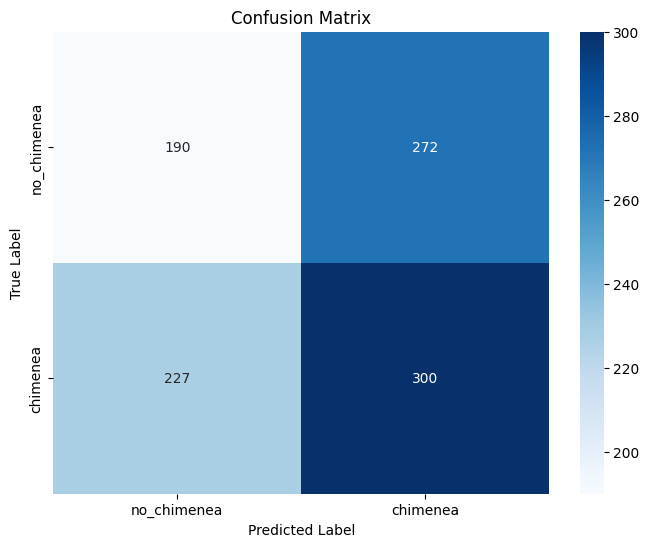

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones del conjunto de prueba
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int).flatten()  # Redondear a 0 o 1

# Obtener etiquetas verdaderas
y_true = test_generator.classes

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases
class_names = ['no_chimenea', 'chimenea']

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

6.c. Curvas ROC y AUC.

124/124 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step


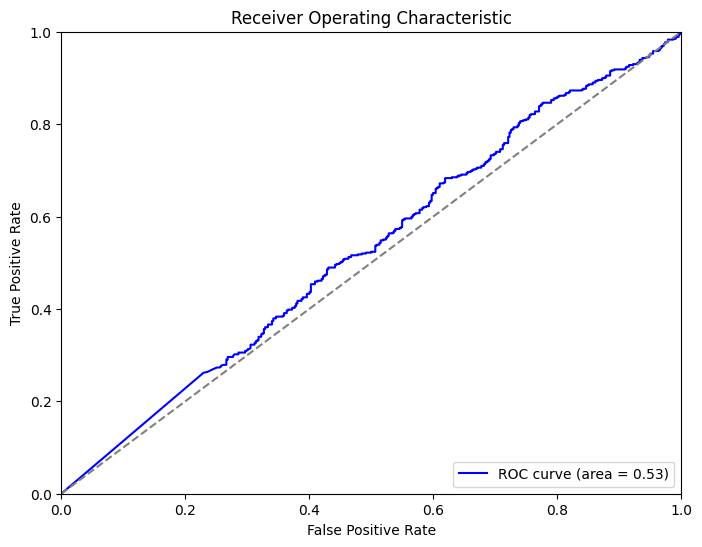

In [11]:
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades predichas
y_pred_prob = model.predict(test_generator).flatten()

# Definir y_true con las etiquetas verdaderas
y_true = test_generator.classes  # Obtiene las etiquetas verdaderas del generador de prueba

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


6.d. Reporte de clasificación.

In [12]:
from sklearn.metrics import classification_report
# Obtener predicciones binarizadas (0 o 1)
y_pred = np.round(y_pred_prob).astype(int)

# Etiquetas de las clases
class_names = ['no_chimenea', 'chimenea']

# Generar y mostrar el reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 no_chimenea       0.49      0.44      0.46       462
    chimenea       0.55      0.60      0.57       527

    accuracy                           0.52       989
   macro avg       0.52      0.52      0.52       989
weighted avg       0.52      0.52      0.52       989



6.e. Curvas de pérdida y precisión **por época**. Este paso requiere acceso al historial de entrenamiento del modelo *(archivo history.npy)*. Si el modelo fue entrenado en esta misma sesión, mantenemos la segunda línea comentada.

In [ ]:
# Cargar el historial de entrenamiento desde el archivo
#history = np.load('/content/drive/My Drive/sinrepco_fotos/history.npy', allow_pickle=True).item() # Descomentar esta línea solo si estamos cargando un modelo creado en una sesión anterior

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

6.f. Gráfica de Precision-Recall.

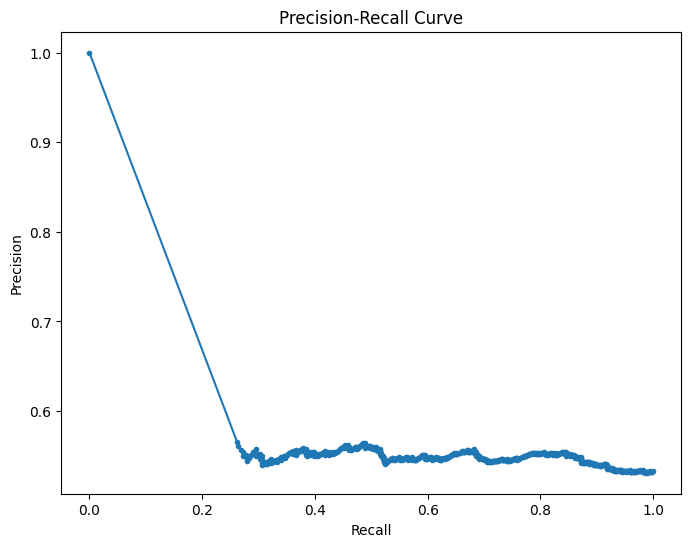

In [14]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

7. 7.a. **Guardar** el modelo ya entrenado en Drive (para no tener que ejecutar el paso 5 nuevamente). *Tamaño del modelo actual: 2.89 GB*.

In [9]:
# Guardar el modelo en formato Keras nativo en la carpeta sinrepco_Fotos en Drive
model_path = '/content/drive/My Drive/sinrepco_fotos/saved_model.keras'

# Guardar el modelo entrenado en la ruta especificada
model.save(model_path)


7.b. Guardar el historial de entrenamiento del modelo en Drive (*para cargarlo y usarlo en el paso 6.e.*).

In [ ]:
# Guardar el historial en un archivo .npy
np.save('/content/drive/My Drive/sinrepco_fotos/history.npy', history.history)

7.c. Descargar el modelo en el equipo local (más demorado).

In [ ]:
# Guardar el modelo en formato Keras nativo en el almacenamiento local de Colab
model_path = '/content/saved_model.keras'

# Guardar el modelo entrenado en la ruta especificada
model.save(model_path)

# Descargar el modelo a tu equipo
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8. **Cargar** el modelo a la sesión actual (para usar un modelo guardado anteriormente).

In [6]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/My Drive/sinrepco_fotos/saved_model.keras')

# A continuación
Deberemos desarrollar el subsistema de reconocimiento de placas vehiculares. Para futuras fases, deberemos integrar los dos subsistemas y desarrollar la función de publicación automatizada en X (antes Twitter).
Gracias por leer.